# Extracción de datos de Previsión de Generación Termosolar

Los datos de previsión de generación son proporcionados por la empresa **Meteologica**.
Estas previsiones son insertadas de manera diaria en la base de datos de Axpo, empresa que colabora con la realización de este TFM.

La obtención de los datos se realiza de la base de datos SQL de **Axpo** que actua como concentrador de previsiones de las diferentes instalaciones en la cartera.

A través de la siguiente query se obtienen los datos de previsión horaria para la UFI que representa la unidad de generación objeto de este estudio.
Por LPD se utiliza un Alias en sustitución de la Unidad Fisica que es el codigo de indentificación de la instalación en el sistema.

~~~~sql
    SELECT CAB.FESESION,DET.HORA,CAB.VERPREV,DET.ENERGIA,CAB.FEULTMOD,ENV.CDUSUARIO
    FROM [EGL_READ].[dbo].[CAB_PREVISION] CAB
        INNER JOIN [EGL_READ].[dbo].[DET_PREVISION] DET ON CAB.CDPREV=DET.CDPREV AND CAB.VERPREV=DET.VERPREV
        INNER JOIN [EGL_READ].[dbo].[ENVIO_PREVISIONES] ENV ON CAB.CDENVIO=ENV.CDENVIO
    WHERE CAB.FESESION >= '2021-01-01' AND CAB.CDUNIFIS='SOLAR'
    AND CAB.VERPREV IN (SELECT MIN(CAB1.VERPREV) FROM [EGL_READ].[dbo].[CAB_PREVISION] CAB1
        INNER JOIN [EGL_READ].[dbo].[ENVIO_PREVISIONES] ENV1 ON CAB1.CDENVIO=ENV1.CDENVIO
    WHERE CAB1.CDPREV=CAB.CDPREV) \n",
    ORDER BY CAB.FESESION,DET.HORA,CAB.VERPREV



El resultado de esta query se exporta en archivo csv separado por comas

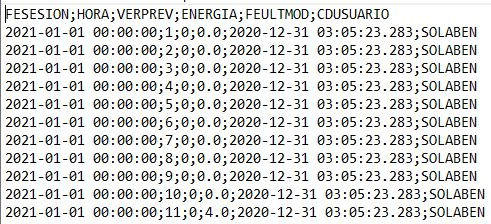

## 1.Importado de librerias

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.Carga de datos desde fichero externo (csv)

In [43]:
from google.colab import drive
drive.mount('/content/drive')
prev=pd.read_csv("/content/drive/MyDrive/TFM_Kschool/2.RECOPILACION_DE_DATOS/2.2_REPOSITORIO_DATOS_BRUTOS/Copia de PREVISIONES_BRUTO (1).csv",sep=";")
prev.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FESESION,HORA,VERPREV,ENERGIA,FEULTMOD,CDUSUARIO
0,2021-01-01 00:00:00,1,0,0.0,2020-12-31 03:05:23.283,SOLABEN
1,2021-01-01 00:00:00,2,0,0.0,2020-12-31 03:05:23.283,SOLABEN
2,2021-01-01 00:00:00,3,0,0.0,2020-12-31 03:05:23.283,SOLABEN
3,2021-01-01 00:00:00,4,0,0.0,2020-12-31 03:05:23.283,SOLABEN
4,2021-01-01 00:00:00,5,0,0.0,2020-12-31 03:05:23.283,SOLABEN


##3.Procesado y limpieza del dato

Comprobamos el tipo de dato del csv para evaluar si es necesario una conversión del tipo de dato.

In [44]:
prev.dtypes

FESESION      object
HORA           int64
VERPREV        int64
ENERGIA      float64
FEULTMOD      object
CDUSUARIO     object
dtype: object

Es necesario la conversion de las variables FESESION a Fecha sin hora ya que siempre es 00:00.
Las variables FEULTMOD y CDUSUARIO no van a ser relevantes para el estudio por lo que se eliminan del dataset.

In [45]:
#conversion FESESION a fecha simple
prev['FESESION']=pd.to_datetime(prev['FESESION'])
prev.dtypes

#Borrado de las columnas FEULTMOD y CDUSUARIO
del prev['CDUSUARIO']
del prev['FEULTMOD']
prev.head()

,FESESION,HORA,VERPREV,ENERGIA
0,2021-01-01,1,0,0.0
1,2021-01-01,2,0,0.0
2,2021-01-01,3,0,0.0
3,2021-01-01,4,0,0.0
4,2021-01-01,5,0,0.0


La Central termosolar tiene una potencia nominal de 49.0 MW por lo que cualquier valor por encima de ese limite se considerará erroneo. Las previsiones no pueden tener valores inferiores a 0 ya que solo se considera la energia exportada, siendo el criterio de signos (+) producción y (-) consumo.

Para ello se verifican los maximos y minimos del dataset para comprobar que se encuentran en ese intervalo.

In [56]:
#MAX
print(prev.max())
#MIN
print(prev.min())

FESESION    2023-11-29 00:00:00
HORA                         25
VERPREV                       7
ENERGIA                    49.0
dtype: object
FESESION    2021-01-01 00:00:00
HORA                          1
VERPREV                       0
ENERGIA                     0.0
dtype: object


La maxima prevision cumple la maxima potencia instalada y no existen valores negativos. No hay valores fuera de escala.

## 4.Exportado dato procesado

In [59]:
prev.to_csv("/content/drive/MyDrive/TFM_Kschool/2.RECOPILACION_DE_DATOS/2.3_REPOSITORIO_DATOS_PROCESADOS/PREVISIONES_PROCESADOS.csv",sep=";")